In [ ]:
!pip3 install torch torchvision
!pip3 install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/')

# Step 2: Define the folder path
folder_path = "/content/drive/My Drive/YOLOv11-litter-detec-folder"

# Step 3: Check contents of the folder
import os
if os.path.exists(folder_path):
    print(f"Contents of {folder_path}:")
    print(os.listdir(folder_path))
else:
    print(f"Folder {folder_path} does not exist. Check the path.")


Mounted at /content/drive/
Contents of /content/drive/My Drive/YOLOv11-litter-detec-folder:
['yolo11m.pt', 'dataset_custom.yaml', 'yolo11m-custom-litter-best.pt', 'yolo11x.pt', 'yolo11x-custom-litter-best.pt', 'yolo11n.pt', 'yolo11n-custom-litter-best.pt', 'vecteezy_a-city-s-garbage_1803529.gif', 'val', 'train']


In [ ]:
# Import necessary libraries
import os
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import time

# Define dataset paths
train_path = "/content/drive/MyDrive/YOLOv11-litter-detec-folder/train"
val_path = "/content/drive/MyDrive/YOLOv11-litter-detec-folder/val"
num_epochs = 100

# Define object classes
classes = [
    "Aerosol can", "Aluminium foil", "Battery", "Blister pack", "Bottle",
    "Bottle cap", "Broken glass", "Can", "Carton", "Cigarette", "Cup",
    "Food waste", "Glass jar", "Lid", "Other plastic", "Paper", "Paper bag",
    "Plastic bag & wrapper", "Plastic container", "Plastic gloves",
    "Plastic utensils", "Pop tab", "Rope & strings", "Scrap metal", "Shoe",
    "Squeezable tube", "Straw", "Styrofoam piece", "Unlabeled litter"
]

# Helper function to load annotations
class CustomDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted([f for f in os.listdir(os.path.join(root, "images")) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]))
        self.labels = list(sorted([f for f in os.listdir(os.path.join(root, "labels")) if f.lower().endswith('.txt')]))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        label_path = os.path.join(self.root, "labels", self.labels[idx])
        img = F.to_tensor(plt.imread(img_path))

        # Parse label file
        boxes, labels = [], []
        with open(label_path) as f:
            for line in f:
                data = line.split()
                labels.append(int(data[0]))
                x_center, y_center, width, height = map(float, data[1:])
                x_min = (x_center - width / 2) * img.shape[2]
                y_min = (y_center - height / 2) * img.shape[1]
                x_max = (x_center + width / 2) * img.shape[2]
                y_max = (y_center + height / 2) * img.shape[1]
                boxes.append([x_min, y_min, x_max, y_max])

        if len(boxes) == 0:  # Handle images with no bounding boxes
            boxes = [[0, 0, 1, 1]]
            labels = [0]

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {"boxes": boxes, "labels": labels}

        if self.transforms:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

# Load datasets
train_dataset = CustomDataset(train_path)
val_dataset = CustomDataset(val_path)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Define model
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# Function to compute IoU
def compute_iou(box, gt_boxes):
    x_min = np.maximum(box[0], gt_boxes[:, 0])
    y_min = np.maximum(box[1], gt_boxes[:, 1])
    x_max = np.minimum(box[2], gt_boxes[:, 2])
    y_max = np.minimum(box[3], gt_boxes[:, 3])
    intersection = np.maximum(0, x_max - x_min) * np.maximum(0, y_max - y_min)
    box_area = (box[2] - box[0]) * (box[3] - box[1])
    gt_areas = (gt_boxes[:, 2] - gt_boxes[:, 0]) * (gt_boxes[:, 3] - gt_boxes[:, 1])
    union = box_area + gt_areas - intersection
    return intersection / union

# Function to calculate metrics
def calculate_metrics(outputs, targets, iou_threshold=0.5):
    tp, fp, fn = 0, 0, 0
    for i, output in enumerate(outputs):
        pred_boxes = output["boxes"].cpu().numpy()
        pred_labels = output["labels"].cpu().numpy()
        gt_boxes = targets[i]["boxes"].cpu().numpy()
        gt_labels = targets[i]["labels"].cpu().numpy()
        matched = set()
        for j, pred_box in enumerate(pred_boxes):
            iou = compute_iou(pred_box, gt_boxes)
            if iou.max() >= iou_threshold and pred_labels[j] in gt_labels:
                tp += 1
                matched.add(iou.argmax())
            else:
                fp += 1
        fn += len(gt_boxes) - len(matched)
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    return precision, recall

# Training function
def train_model(model, train_loader, val_loader, device, num_epochs):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    metrics_df = pd.DataFrame(columns=[
        "epoch", "time", "train/box_loss", "train/cls_loss", "train/dfl_loss",
        "metrics/precision(B)", "metrics/recall(B)", "val/box_loss", "val/cls_loss", "val/dfl_loss",
        "lr/pg0", "lr/pg1", "lr/pg2"
    ])

    for epoch in range(num_epochs):
        start_time = time()
        model.train()
        train_box_loss, train_cls_loss, train_dfl_loss = 0, 0, 0
        for images, targets in train_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            train_box_loss += loss_dict.get("loss_box_reg", torch.tensor(0.0)).item()
            train_cls_loss += loss_dict.get("loss_classifier", torch.tensor(0.0)).item()
            train_dfl_loss += sum(loss_dict.values()).item()
            optimizer.zero_grad()
            sum(loss_dict.values()).backward()
            optimizer.step()

        model.eval()
        val_box_loss, val_cls_loss, val_dfl_loss, precision, recall = 0, 0, 0, 0, 0
        with torch.no_grad():
            for images, targets in val_loader:
                images = [img.to(device) for img in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                # Temporarily switch to training mode to calculate validation losses
                model.train()
                loss_dict = model(images, targets)
                val_box_loss += loss_dict.get("loss_box_reg", torch.tensor(0.0)).item()
                val_cls_loss += loss_dict.get("loss_classifier", torch.tensor(0.0)).item()
                val_dfl_loss += sum(loss_dict.values()).item()
                model.eval()

                # Calculate precision and recall
                outputs = model(images)
                batch_precision, batch_recall = calculate_metrics(outputs, targets)
                precision += batch_precision
                recall += batch_recall

        precision /= len(val_loader)
        recall /= len(val_loader)
        val_box_loss /= len(val_loader)
        val_cls_loss /= len(val_loader)
        val_dfl_loss /= len(val_loader)

        # Log learning rates dynamically
        learning_rates = [pg["lr"] for pg in optimizer.param_groups]

        end_time = time()

        new_row = pd.DataFrame([{
            "epoch": epoch + 1,
            "time": round(end_time - start_time, 2),
            "train/box_loss": train_box_loss / len(train_loader),
            "train/cls_loss": train_cls_loss / len(train_loader),
            "train/dfl_loss": train_dfl_loss / len(train_loader),
            "metrics/precision(B)": precision,
            "metrics/recall(B)": recall,
            "val/box_loss": val_box_loss,
            "val/cls_loss": val_cls_loss,
            "val/dfl_loss": val_dfl_loss,
            "lr/pg0": learning_rates[0] if len(learning_rates) > 0 else None,
            "lr/pg1": learning_rates[1] if len(learning_rates) > 1 else None,
            "lr/pg2": learning_rates[2] if len(learning_rates) > 2 else None,
        }])
        metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)
        print(metrics_df.tail(1).to_string(index=False))

    return model, metrics_df


# Initialize and train the model
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")
model = get_model(num_classes=len(classes) + 1)
model, metrics_df = train_model(model, train_loader, val_loader, device, num_epochs)

# Save metrics and model
metrics_df.to_csv(f"training_metrics_{num_epochs}_epochs.csv", index=False)
torch.save(model.state_dict(), f"faster_rcnn_model_{num_epochs}_epochs.pth")


Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-4-2ff388d46ce1>:189: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.conca

epoch  time  train/box_loss  train/cls_loss  train/dfl_loss  metrics/precision(B)  metrics/recall(B)  val/box_loss  val/cls_loss  val/dfl_loss  lr/pg0 lr/pg1 lr/pg2
    1  91.8        0.171541         0.28695        0.541697              0.097235           0.756197      0.120417      0.176314      0.332186  0.0001   None   None
epoch  time  train/box_loss  train/cls_loss  train/dfl_loss  metrics/precision(B)  metrics/recall(B)  val/box_loss  val/cls_loss  val/dfl_loss  lr/pg0 lr/pg1 lr/pg2
    2  90.1        0.136435        0.236882        0.411362              0.069277            0.72197      0.094721      0.164729      0.292672  0.0001   None   None
epoch  time  train/box_loss  train/cls_loss  train/dfl_loss  metrics/precision(B)  metrics/recall(B)  val/box_loss  val/cls_loss  val/dfl_loss  lr/pg0 lr/pg1 lr/pg2
    3 90.09        0.111763        0.196327         0.33387              0.131805           0.739835      0.095525      0.143441      0.262339  0.0001   None   None
epoch  tim

# added mAP50. and mAP50-95

In [ ]:
# Import necessary libraries
import os
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import time
from collections import defaultdict

# ----------------------------
#   1) DATASET DEFINITION
# ----------------------------

train_path = "/content/drive/MyDrive/YOLOv11-litter-detec-folder/train"
val_path   = "/content/drive/MyDrive/YOLOv11-litter-detec-folder/val"
num_epochs = 100

classes = [
    "Aerosol can", "Aluminium foil", "Battery", "Blister pack", "Bottle",
    "Bottle cap", "Broken glass", "Can", "Carton", "Cigarette", "Cup",
    "Food waste", "Glass jar", "Lid", "Other plastic", "Paper", "Paper bag",
    "Plastic bag & wrapper", "Plastic container", "Plastic gloves",
    "Plastic utensils", "Pop tab", "Rope & strings", "Scrap metal", "Shoe",
    "Squeezable tube", "Straw", "Styrofoam piece", "Unlabeled litter"
]
num_classes = len(classes) + 1  # +1 for background (class 0)

class CustomDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted([
            f for f in os.listdir(os.path.join(root, "images"))
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ]))
        self.labels = list(sorted([
            f for f in os.listdir(os.path.join(root, "labels"))
            if f.lower().endswith('.txt')
        ]))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        label_path = os.path.join(self.root, "labels", self.labels[idx])

        # Read image
        img_array = plt.imread(img_path)
        # If it’s a grayscale or RGBA, convert accordingly to 3 channels
        if len(img_array.shape) == 2:
            # Grayscale -> RGB
            img_array = np.stack([img_array]*3, axis=-1)
        elif img_array.shape[2] == 4:
            # RGBA -> RGB
            img_array = img_array[..., :3]
        img = F.to_tensor(img_array)

        # Parse label file
        boxes, labels = [], []
        with open(label_path) as f:
            for line in f:
                data = line.split()
                labels.append(int(data[0]))  # class index
                x_center, y_center, width, height = map(float, data[1:])
                x_min = (x_center - width / 2) * img.shape[2]
                y_min = (y_center - height / 2) * img.shape[1]
                x_max = (x_center + width / 2) * img.shape[2]
                y_max = (y_center + height / 2) * img.shape[1]
                boxes.append([x_min, y_min, x_max, y_max])

        # Handle images with no bounding boxes
        if len(boxes) == 0:
            boxes  = [[0, 0, 1, 1]]
            labels = [0]

        boxes  = torch.as_tensor(boxes,  dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {"boxes": boxes, "labels": labels}

        if self.transforms:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

train_dataset = CustomDataset(train_path)
val_dataset   = CustomDataset(val_path)

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset,   batch_size=4, shuffle=False, collate_fn=collate_fn)


# ----------------------------
#   2) MODEL DEFINITION
# ----------------------------

def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model


# ----------------------------
#   3) mAP EVALUATION
# ----------------------------

def compute_iou(boxA, boxB):
    """
    Compute IoU between a single boxA and multiple boxB boxes:
    boxA: shape (4,)  -> [x1, y1, x2, y2]
    boxB: shape (N,4) -> [x1, y1, x2, y2]
    """
    xA = np.maximum(boxA[0], boxB[:, 0])
    yA = np.maximum(boxA[1], boxB[:, 1])
    xB = np.minimum(boxA[2], boxB[:, 2])
    yB = np.minimum(boxA[3], boxB[:, 3])

    interArea = np.maximum(0, xB - xA) * np.maximum(0, yB - yA)
    boxAArea  = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea  = (boxB[:, 2] - boxB[:, 0]) * (boxB[:, 3] - boxB[:, 1])
    iou = interArea / (boxAArea + boxBArea - interArea + 1e-6)
    return iou

def evaluate_map(model, data_loader, device, iou_thresholds=None, score_threshold=0.0):
    """
    Evaluate mean Average Precision for IoU in [0.5:0.95] with step=0.05 (COCO style),
    plus the specific case IoU=0.50 (Pascal VOC style).
    - model: your trained model
    - data_loader: validation loader
    - device: 'cuda' or 'cpu'
    - iou_thresholds: list/array of IoU thresholds to test. If None, defaults to np.arange(0.5, 1.0, 0.05).
    - score_threshold: filter out predictions with a confidence below this threshold
    """
    if iou_thresholds is None:
        iou_thresholds = np.arange(0.5, 1.0, 0.05)

    model.eval()

    # We will store all predictions and GTs for each class
    # predictions[class_id] = list of (score, is_tp_or_fp)
    # total_gts[class_id] = total number of ground-truth boxes for that class
    predictions = defaultdict(list)  # {class_id: [(score, TP/FP), ...], ...}
    total_gts   = defaultdict(int)   # {class_id: count_of_gt}

    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)

            for out, tgt in zip(outputs, targets):
                # Convert to CPU numpy
                pred_boxes  = out["boxes"].cpu().numpy()
                pred_labels = out["labels"].cpu().numpy()
                pred_scores = out["scores"].cpu().numpy()

                gt_boxes  = tgt["boxes"].cpu().numpy()
                gt_labels = tgt["labels"].cpu().numpy()

                # Count how many GT boxes per class
                for gt_label in gt_labels:
                    total_gts[int(gt_label)] += 1

                # Filter out predictions below score_threshold
                keep = pred_scores >= score_threshold
                pred_boxes  = pred_boxes[keep]
                pred_labels = pred_labels[keep]
                pred_scores = pred_scores[keep]

                # For matching, we do a standard procedure:
                # 1) Sort predictions by descending score
                # 2) For each prediction, find best IoU with a GT of the same class that is not yet matched
                #    Mark it as TP if IoU >= threshold (handled later), otherwise FP.
                # We'll store all in a structure for now, then loop over IoU thresholds.
                # => We store them in predictions dict with an indicator that says "pending GT match" + the box.

                # We'll store the box for each pred, so we can do the matching separately for each IoU threshold.
                # Let's keep them in a single pass container:
                # predictions[class_id] = [(score, box, matched?), ...], matched? will be assigned after.
                indices_sorted = np.argsort(-pred_scores)  # descending
                pred_boxes  = pred_boxes[indices_sorted]
                pred_labels = pred_labels[indices_sorted]
                pred_scores = pred_scores[indices_sorted]

                # We keep track of GT boxes used per class, then match them after.
                # For mAP, we do the matching per IoU threshold, so let's store data in a workable structure:
                for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
                    # ignore background label = 0 if you have it
                    if label == 0:
                        continue
                    predictions[int(label)].append((score, box, gt_boxes[gt_labels == label]))

    # Now we compute the AP for each class, for each IoU threshold, then average.
    # For each IoU threshold, we do a standard "predictions sorted by score" approach:
    AP_per_class = {th: np.zeros(num_classes) for th in iou_thresholds}
    valid_classes = [c for c in range(1, num_classes)]  # exclude background=0

    for class_id in valid_classes:
        # Gather all predictions for this class across the dataset
        # each entry: (score, box, array_of_gt_boxes_for_that_class_in_that_image)
        class_preds = predictions[class_id]
        if len(class_preds) == 0:
            # no predictions for that class
            for th in iou_thresholds:
                AP_per_class[th][class_id] = 0.0
            continue

        # Sort by descending confidence
        class_preds.sort(key=lambda x: x[0], reverse=True)

        # We must loop over each IoU threshold and do matching:
        for th in iou_thresholds:
            TP = np.zeros(len(class_preds), dtype=np.float32)
            FP = np.zeros(len(class_preds), dtype=np.float32)

            # Keep track of which GT boxes were matched (per image).
            # But we stored all GT boxes for each prediction. We need a robust way to mark them matched or not.
            # Since we didn't keep an ID for each GT box individually, we can do a simpler approach:
            #   For each prediction, we see if there's any GT box with IoU >= th. If yes, it's a potential match.
            #   But we must ensure we match each GT box at most once, so we keep track of matched boxes with a set.
            # We'll keep the matched boxes in a global sense for that threshold? Actually we need it per *image*.
            matched_flags_list = []
            for idx_pred, (score, pred_box, gt_boxes_same_image) in enumerate(class_preds):
                if len(gt_boxes_same_image) == 0:
                    # No GT boxes for that label in that image => it's a false positive
                    FP[idx_pred] = 1
                    matched_flags_list.append([])  # no GT to match with
                else:
                    # We'll create a matched array if not existing yet
                    matched_array = np.zeros(len(gt_boxes_same_image), dtype=bool)
                    # find best IoU
                    ious = compute_iou(pred_box, gt_boxes_same_image)
                    max_iou_idx = np.argmax(ious)
                    max_iou_val = ious[max_iou_idx]
                    if max_iou_val >= th and not matched_array[max_iou_idx]:
                        # It's a true positive
                        TP[idx_pred] = 1
                        matched_array[max_iou_idx] = True
                    else:
                        # It's a false positive
                        FP[idx_pred] = 1
                    matched_flags_list.append(matched_array)

            # Now we compute precision & recall for this class at IoU=th by
            # stepping through the sorted detections:
            acc_TP = np.cumsum(TP)
            acc_FP = np.cumsum(FP)
            recalls    = acc_TP / (total_gts[class_id] + 1e-6)
            precisions = acc_TP / (acc_TP + acc_FP + 1e-6)

            # AP is the area under precision-recall curve
            recalls    = np.concatenate(([0.0], recalls))
            precisions = np.concatenate(([1.0], precisions))
            for i in range(len(precisions) - 1, 0, -1):
                precisions[i-1] = max(precisions[i-1], precisions[i])

            # Compute area under curve
            indices = np.where(recalls[1:] != recalls[:-1])[0]
            ap = 0.0
            for i in indices:
                ap += (recalls[i+1] - recalls[i]) * precisions[i+1]
            AP_per_class[th][class_id] = ap

    # Now average AP across classes for each threshold:
    mAPs = []
    for th in iou_thresholds:
        # exclude background=0 from the average
        valid_APs = [AP_per_class[th][cid] for cid in valid_classes]
        mAPs.append(np.mean(valid_APs))

    # mAP@50 is the first threshold (assuming iou_thresholds[0] = 0.5)
    map_50 = mAPs[0]
    # Average across all thresholds
    map_50_95 = np.mean(mAPs)

    return map_50, map_50_95


# ----------------------------
#   4) TRAINING LOOP
# ----------------------------

def train_model(model, train_loader, val_loader, device, num_epochs):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    metrics_df = pd.DataFrame(columns=[
        "epoch", "time",
        "train/box_loss", "train/cls_loss", "train/dfl_loss",
        "metrics/precision(B)", "metrics/recall(B)",
        "val/box_loss", "val/cls_loss", "val/dfl_loss",
        "metrics/mAP@50", "metrics/mAP@50-95",
        "lr/pg0", "lr/pg1", "lr/pg2"
    ])

    for epoch in range(num_epochs):
        start_time = time()
        model.train()

        # ----------------------
        # Training step
        # ----------------------
        train_box_loss, train_cls_loss, train_dfl_loss = 0.0, 0.0, 0.0
        for images, targets in train_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            loss_box = loss_dict.get("loss_box_reg", torch.tensor(0.0))
            loss_cls = loss_dict.get("loss_classifier", torch.tensor(0.0))
            loss_sum = sum(loss_dict.values())

            train_box_loss += loss_box.item()
            train_cls_loss += loss_cls.item()
            train_dfl_loss += loss_sum.item()

            optimizer.zero_grad()
            loss_sum.backward()
            optimizer.step()

        train_box_loss /= len(train_loader)
        train_cls_loss /= len(train_loader)
        train_dfl_loss /= len(train_loader)

        # ----------------------
        # Validation step
        # ----------------------
        model.eval()
        val_box_loss, val_cls_loss, val_dfl_loss = 0.0, 0.0, 0.0
        precision, recall = 0.0, 0.0

        with torch.no_grad():
            for images, targets in val_loader:
                images = [img.to(device) for img in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                # Switch briefly to train mode to get val losses
                model.train()
                loss_dict_val = model(images, targets)
                val_box_loss  += loss_dict_val.get("loss_box_reg", torch.tensor(0.0)).item()
                val_cls_loss  += loss_dict_val.get("loss_classifier", torch.tensor(0.0)).item()
                val_dfl_loss  += sum(loss_dict_val.values()).item()
                model.eval()

                # Quick precision/recall at IoU=0.5
                outputs = model(images)
                batch_tp, batch_fp, batch_fn = 0, 0, 0
                iou_threshold = 0.5
                for i, out in enumerate(outputs):
                    pred_boxes  = out["boxes"].cpu().numpy()
                    pred_labels = out["labels"].cpu().numpy()
                    gt_boxes  = targets[i]["boxes"].cpu().numpy()
                    gt_labels = targets[i]["labels"].cpu().numpy()
                    matched = set()
                    for j, pbox in enumerate(pred_boxes):
                        # simple IoU checking
                        ious = compute_iou(pbox, gt_boxes)
                        max_iou_id  = np.argmax(ious)
                        max_iou_val = ious[max_iou_id]
                        # check if same class
                        if max_iou_val >= iou_threshold and pred_labels[j] in gt_labels:
                            # if class matches, count as TP
                            batch_tp += 1
                            matched.add(max_iou_id)
                        else:
                            batch_fp += 1
                    batch_fn += len(gt_boxes) - len(matched)

                batch_precision = batch_tp / (batch_tp + batch_fp + 1e-6)
                batch_recall    = batch_tp / (batch_tp + batch_fn + 1e-6)
                precision += batch_precision
                recall    += batch_recall

        precision /= len(val_loader)
        recall    /= len(val_loader)
        val_box_loss /= len(val_loader)
        val_cls_loss /= len(val_loader)
        val_dfl_loss /= len(val_loader)

        # Now compute mAP@50 and mAP@50-95 in one pass
        map_50, map_50_95 = evaluate_map(model, val_loader, device)

        # Learning rates
        learning_rates = [pg["lr"] for pg in optimizer.param_groups]

        end_time = time()
        new_row = pd.DataFrame([{
            "epoch": epoch + 1,
            "time": round(end_time - start_time, 2),
            "train/box_loss": train_box_loss,
            "train/cls_loss": train_cls_loss,
            "train/dfl_loss": train_dfl_loss,
            "metrics/precision(B)": precision,
            "metrics/recall(B)": recall,
            "val/box_loss": val_box_loss,
            "val/cls_loss": val_cls_loss,
            "val/dfl_loss": val_dfl_loss,
            "metrics/mAP@50": map_50,
            "metrics/mAP@50-95": map_50_95,
            "lr/pg0": learning_rates[0] if len(learning_rates) > 0 else None,
            "lr/pg1": learning_rates[1] if len(learning_rates) > 1 else None,
            "lr/pg2": learning_rates[2] if len(learning_rates) > 2 else None,
        }])
        metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

        print(metrics_df.tail(1).to_string(index=False))

    return model, metrics_df


# ----------------------------
#   5) MAIN SCRIPT
# ----------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = get_model(num_classes)
model, metrics_df = train_model(model, train_loader, val_loader, device, num_epochs)

# Save metrics and model
metrics_filename = f"training_metrics_{num_epochs}_epochs.csv"
model_filename   = f"faster_rcnn_model_{num_epochs}_epochs.pth"
metrics_df.to_csv(metrics_filename, index=False)
torch.save(model.state_dict(), model_filename)

print(f"Training complete. Metrics saved to {metrics_filename}, model saved to {model_filename}.")


Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 202MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:154: UserWarning: The given NumPy array is not writab

epoch   time  train/box_loss  train/cls_loss  train/dfl_loss  metrics/precision(B)  metrics/recall(B)  val/box_loss  val/cls_loss  val/dfl_loss  metrics/mAP@50  metrics/mAP@50-95  lr/pg0 lr/pg1 lr/pg2
    1 298.37        0.167424        0.305286        0.555003              0.072284           0.793532      0.126622      0.193116      0.344181        0.065191           0.023421  0.0001   None   None
epoch  time  train/box_loss  train/cls_loss  train/dfl_loss  metrics/precision(B)  metrics/recall(B)  val/box_loss  val/cls_loss  val/dfl_loss  metrics/mAP@50  metrics/mAP@50-95  lr/pg0 lr/pg1 lr/pg2
    2 97.94        0.134699        0.234534        0.443743              0.090626           0.822066      0.102251      0.185649      0.318669        0.137136           0.062385  0.0001   None   None
epoch  time  train/box_loss  train/cls_loss  train/dfl_loss  metrics/precision(B)  metrics/recall(B)  val/box_loss  val/cls_loss  val/dfl_loss  metrics/mAP@50  metrics/mAP@50-95  lr/pg0 lr/pg1 lr/pg

# Plot metrics from CSV

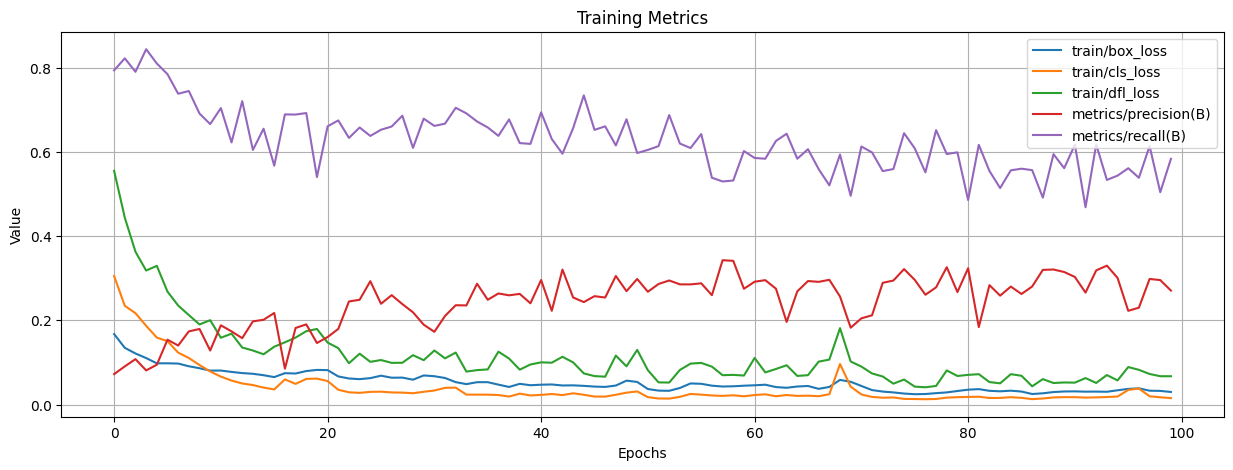

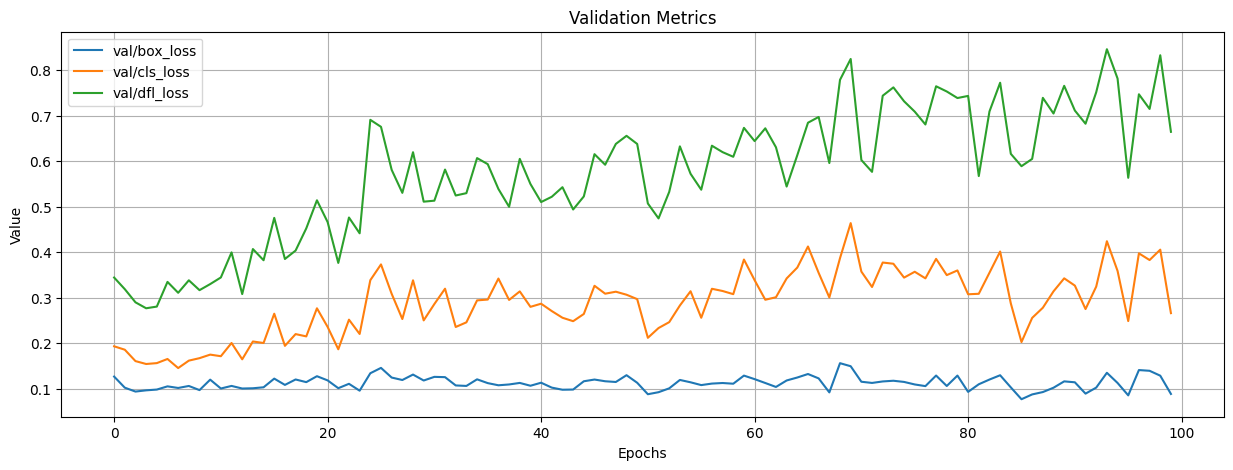

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = '/content/training_metrics_100_epochs.csv'
df = pd.read_csv(file_path)

# Plotting function
def plot_metrics(metrics, title):
    plt.figure(figsize=(15, 5))
    for metric in metrics:
        if metric in df.columns:
            plt.plot(df[metric], label=metric)
        else:
            print(f"Warning: {metric} not found in the dataset.")

    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot training metrics
plot_metrics([
    'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
    'metrics/precision(B)', 'metrics/recall(B)'
], 'Training Metrics')

# Plot validation metrics
plot_metrics([
    'val/box_loss', 'val/cls_loss', 'val/dfl_loss'
], 'Validation Metrics')


# new design

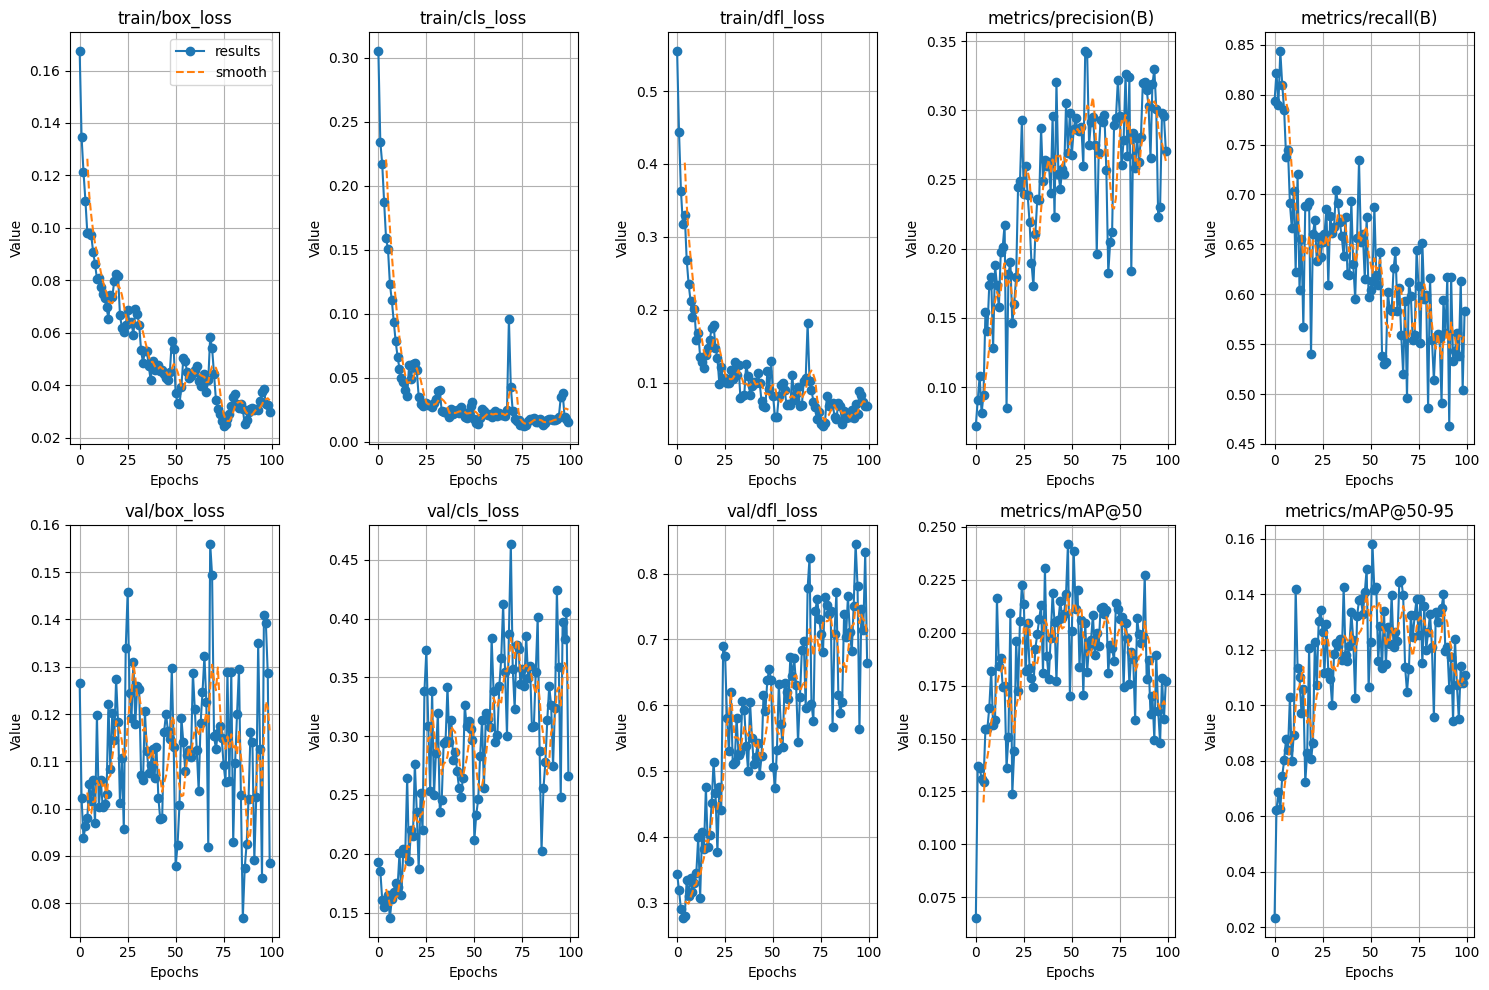

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the CSV file
file_path = '/content/training_metrics_100_epochs.csv'
df = pd.read_csv(file_path)

# List of metrics to plot
metrics = [
    'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
    'metrics/precision(B)', 'metrics/recall(B)',
    'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
    'metrics/mAP@50', 'metrics/mAP@50-95'
]

# Create a grid layout for the plots
plt.figure(figsize=(15, 10))

# Loop through metrics and assign positions
for idx, metric in enumerate(metrics):
    plt.subplot(2, 5, idx + 1)  # 2 rows, 5 columns grid
    if metric in df.columns:
        plt.plot(df[metric], label='results', marker='o')
        plt.plot(df[metric].rolling(window=5).mean(), label='smooth', linestyle='--')
    else:
        plt.text(0.5, 0.5, f"{metric} not found", ha='center', va='center')

    plt.title(metric)
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.grid(True)
    if idx == 0:
        plt.legend()

plt.tight_layout()
plt.show()

